# Named Entity Recognition using Bi-LSTM with CRF layer
##### Sinem Ertem

### Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

print(keras.__version__)

from math import nan
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.sequence import pad_sequences

from future.utils import iteritems

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

print(k.__version__)

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

2.2.4
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-jt2am9f2
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-jt2am9f2
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=b1cc9bcadba7aa8dbbc95c142af7147302c2f0a5f7c964713a2c44642dd3aa1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mj8i85ke/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
entity-annotated-corpus
voc-processed-data

2.2.4


### Import and prepare dataset

In [49]:
train = pd.read_csv("/kaggle/input/voc-processed-data/train-nl.tsv", sep="\t")
test = pd.read_csv("/kaggle/input/voc-processed-data/test-nl.tsv", sep="\t")
dev = pd.read_csv("/kaggle/input/voc-processed-data/dev-nl.tsv", sep="\t")

data = pd.concat([train, test, dev], ignore_index=True)

data['Sentence #'] = data['TOKEN'].str.extract(r'# document_path = (.*)', expand=False).ffill()
sentence_col = data.pop('Sentence #')
data.insert(0, 'Sentence #', sentence_col)
data = data.dropna()

# create a dictionary to map unique strings to Sentence numbers
sentence_dict = {}
count = 1
for sentence in data['Sentence #'].unique():
    sentence_dict[sentence] = f"Sentence {count}"
    count += 1
# map the 'Sentence #' column with the dictionary
data['Sentence #'] = data['Sentence #'].map(sentence_dict)
data = data.reset_index(drop=True)

In [ ]:
len(data)

In [ ]:
data['NE-MAIN'].value_counts()

In [ ]:
# import itertools

# # Define a function to check for consecutive 'O' values
# def check_consecutive(lst):
#     return any(sum(1 for _ in group) > 4 for _, group in itertools.groupby(lst, lambda x: x=='O') if _)

# # Filter out rows where there are more than 4 consecutive 'O' values
# df_filtered = data[~data.drop(columns=['TOKEN']).apply(check_consecutive, axis=1)]

# # Print the filtered dataframe
# df_filtered.head()

In [ ]:
print(len(train))
print(len(test))
print(len(dev))

In [50]:
df = data[['Sentence #', 'TOKEN', 'NE-PER-LEGAL-STATUS']]
df.head()

,Sentence #,TOKEN,NE-PER-LEGAL-STATUS
0,Sentence 1,heste,O
1,Sentence 1,afschrift,O
2,Sentence 1,m,O
3,Sentence 1,In,O
4,Sentence 1,den,O


In [ ]:
# ## Pre-process imbalanced dataset 
# over_sampler = RandomOverSampler(sampling_strategy="not majority") # Randomly over-sample minority class to have 50% of majority class

# # Apply the over-sampler and under-sampler to the training data
# X_train = data.drop(columns=['NE-MAIN'])
# y_train = data['NE-MAIN']

# # First, under-sample the majority class
# # X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
# # Then, over-sample the minority class on the under-sampled data
# X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

# X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
# y_train_resampled = pd.DataFrame(y_train_resampled, columns=['NE-MAIN'])

# data = pd.concat([X_train_resampled, y_train_resampled], axis=1)
# data.head(10)

### Extract the token and named entity pairs for each sentence in a dataset

In [51]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["TOKEN"].values.tolist(),
                                                    s["NE-PER-LEGAL-STATUS"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [52]:
getter = SentenceGetter(df)
sentences = getter.sentences
print(sentences[0])

[('heste', 'O'), ('afschrift', 'O'), ('m', 'O'), ('In', 'O'), ('den', 'O'), ('Name', 'O'), ('des', 'O'), ('Heeren', 'O'), ('Amen', 'O'), ('C:', 'O'), ('Op', 'O'), ('heden', 'O'), ('den', 'O'), ('Elfden', 'O'), ('April', 'O'), ('Anno', 'O'), ('Een', 'O'), ('Duysend', 'O'), ('seven', 'O'), ('honderd', 'O'), ('ses', 'O'), ('en', 'O'), ('viftigh', 'O'), ('Compareerde', 'O'), ('voor', 'O'), ('mij', 'O'), ('Pieter', 'B-Unspecified'), ('Herstad', 'I-Unspecified'), ('assistent', 'I-Unspecified'), ('en', 'I-Unspecified'), ('geswore', 'I-Unspecified'), ('scriba', 'I-Unspecified'), ('ten', 'O'), ('dezen', 'O'), ('Comptoire;', 'O'), ('en', 'O'), ('voor', 'O'), ('de', 'O'), ('nage', 'O'), ('noemde', 'O'), ('Getuijgen,', 'B-Unspecified'), ('Francois', 'I-Unspecified'), ('Caffin', 'I-Unspecified'), ('Corporaal', 'I-Unspecified'), ('in', 'O'), ('dienst', 'O'), ('der', 'O'), ('EComp:', 'O'), ('alhier;', 'O'), ('zijnde', 'O'), ('hij', 'O'), ('Comparant', 'O'), ('ziek', 'O'), ('te', 'O'), ('bedde', 'O'),

In [34]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 703


### Check how long sentences are so that we can pad them

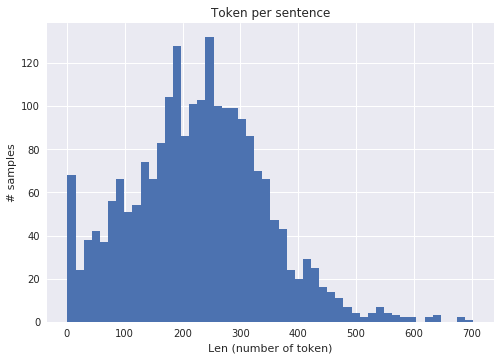

In [8]:
plt.style.use("seaborn")
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [53]:
words = list(set(df["TOKEN"].values))
words.append("ENDPAD")
n_words = len(words); n_words

68354

### Fix the tags

In [54]:
tags = []
for tag in set(df["NE-PER-LEGAL-STATUS"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)
n_tags = len(tags); n_tags

['O', 'I-Unspecified', 'B-Freed', 'B-Unspecified', 'I-Enslaved', 'B-Enslaved', 'I-Freed']


7

### Converting words to numbers and numbers to words

In [55]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

print(tag2idx)
X = [[word2idx[w[0]] for w in s] for s in sentences]
print(np.array(X).shape) # there are 1574 sentences in total data['Sentence #'].value_counts()

X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[100])
print(y_idx[100])

y = pad_sequences(maxlen=140, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[100])

y = [to_categorical(i, num_classes=n_tags) for i in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

{'O': 0, 'I-Unspecified': 1, 'B-Freed': 2, 'B-Unspecified': 3, 'I-Enslaved': 4, 'B-Enslaved': 5, 'I-Freed': 6}
(2199,)
[('woonhuijse', 'O'), ('van', 'O'), ('den', 'O'), ('Heere', 'O'), ('Testateur,', 'O'), ('dato', 'O'), ('voorsz:', 'O'), ('ter', 'O'), ('presentie', 'O'), ('van', 'O'), ('Jan', 'B-Unspecified'), ('Jurgen', 'I-Unspecified'), ('Tieman,', 'I-Unspecified'), ('en', 'O'), ('Johan', 'B-Unspecified'), ('Fredrik', 'I-Unspecified'), ('Samuel', 'I-Unspecified'), ('Neijtje,', 'I-Unspecified'), ('Clercquen', 'O'), ('ter', 'O'), ('secreta„', 'O'), ('rije', 'O'), ('alhier', 'O'), ('als', 'O'), ('getuijgen', 'O'), ('/:was', 'O'), ('geteekend:/', 'O'), ('Cornelis', 'B-Unspecified'), ('Pietersz:', 'I-Unspecified'), ('/:Jn', 'O'), ('margines', 'O'), ('stond', 'O'), ('ons', 'O'), ('present', 'O'), ('/:was', 'O'), ('geteekend', 'O'), ('/:', 'O'), ('J:n', 'B-Unspecified'), ('J:n', 'I-Unspecified'), ('Siman,', 'I-Unspecified'), ('en', 'O'), ('J:', 'B-Unspecified'), ('F:', 'I-Unspecified'), ('

### Model architecture
Pay attention to the word embedding size

In [15]:
from sklearn.utils.class_weight import compute_class_weight

In [56]:
y_train_labels = np.argmax(y_train, axis=-1).flatten()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)

In [57]:
input = Input(shape=(140,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=140)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)

adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 140, 300)          20506200  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140, 600)          1442400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 140, 600)          2882400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 140, 7)            4207      
_________________________________________________________________
crf_3 (CRF)                  (None, 140, 7)            119       
Total params: 24,835,326
Trainable params: 24,835,326
Non-trainable params: 0
________________________________________________________________

### Fit model

In [ ]:
history = model.fit(X_train, np.array(y_train), class_weight=class_weights, batch_size=32, epochs=20, validation_split=0.2, verbose=1)
hist = pd.DataFrame(history.history)

Train on 1407 samples, validate on 352 samples
Epoch 1/20
1407/1407 [==============================] - 171s 121ms/step - loss: 0.6390 - crf_viterbi_accuracy: 0.8696 - acc: 0.9415 - val_loss: 0.3770 - val_crf_viterbi_accuracy: 0.9430 - val_acc: 0.9430
Epoch 2/20
 800/1407 [================>.............] - ETA: 1:06 - loss: 0.3755 - crf_viterbi_accuracy: 0.9401 - acc: 0.9412

# New proposed model architecture, weak/strong classes

In [ ]:
# # Define inputs for the two sets of classes
# strong_input = Input(shape=(140,))
# weak_input = Input(shape=(140,))

# # Embedding layer for strong classes
# strong_embedding_size = 300
# strong_embedded = Embedding(input_dim=n_words, output_dim=strong_embedding_size, input_length=140)(strong_input)

# # Bi-LSTM-CRF network for strong classes
# strong_lstm = Bidirectional(LSTM(units=strong_embedding_size, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_initializer=k.initializers.he_normal()))(strong_embedded)
# strong_lstm = LSTM(units=strong_embedding_size * 2, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_initializer=k.initializers.he_normal())(strong_lstm)
# strong_output = TimeDistributed(Dense(n_tags, activation="relu"))(strong_lstm)

# # RNN-CNN network for weak classes
# weak_embedding_size = 128
# weak_embedded = Embedding(input_dim=n_words, output_dim=weak_embedding_size, input_length=140)(weak_input)
# weak_rnn = Bidirectional(LSTM(units=weak_embedding_size, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(weak_embedded)
# weak_cnn = Conv1D(filters=weak_embedding_size, kernel_size=3, padding="same", activation="relu", strides=1)(weak_rnn)
# weak_output = TimeDistributed(Dense(n_tags, activation="relu"))(weak_cnn)

# # Combine strong and weak outputs using a merge layer and majority voting
# merged_output = concatenate([strong_output, weak_output])
# output = Lambda(function=lambda x: k.backend.mean(x, axis=1))(merged_output)

# # CRF layer
# crf = CRF(n_tags)
# output = crf(output)

# # Create the model
# model = Model(inputs=[strong_input, weak_input], outputs=output)

# # Compile the model
# adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
# model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

In [ ]:
# # Fit the model
# model.fit([X_train_strong, X_train_weak], np.array(y_train), class_weight=class_weights, batch_size=64, epochs=20, validation_split=0.2, verbose=1)

# End

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"],label='Train')
plt.plot(hist["val_crf_viterbi_accuracy"],label='Test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.show()

In [ ]:
plt.style.use("seaborn")
plt.plot(hist["loss"], label="Training Loss")
plt.plot(hist["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Accumulate metrics by tag 

In [ ]:
TP = {}
TN = {}
FP = {}
FN = {}

for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1
        
i = 46
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    print("{:14}: ({:5}): {}".format(words[w], idx2tag[gt[idx]], tags[pred]))

In [ ]:
p = model.predict(np.array(X_test))  

Grab the 3d dimension and return the index of the highest probability ... the index matches the tag value
np.argmax(p, axis=2)

In [ ]:
np.argmax(p, axis=2)[0]

In [ ]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

## Accumulate the scores by tag

In [ ]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(p[i], axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

# create a pandas dataframe with the tag classification metrics
data = {'tag': list(tag2idx.keys()),
        'TN': [TN[tag] for tag in tag2idx.keys()],
        'FP': [FP[tag] for tag in tag2idx.keys()],
        'FN': [FN[tag] for tag in tag2idx.keys()],
        'TP': [TP[tag] for tag in tag2idx.keys()]}
df = pd.DataFrame(data)

# melt the dataframe to long format
df_melt = pd.melt(df, id_vars=['tag'], value_vars=['TN', 'FP', 'FN', 'TP'],
                  var_name='metric', value_name='count')

# create a pivot table for the heatmap
pivot = pd.pivot_table(df_melt, values='count', index=['tag'], columns=['metric'])

# plot the heatmap
sns.heatmap(pivot, cmap='Blues', annot=True, fmt='d')